Deep artificial neural network for expressive timing and dynamics predictions in musical pieces
---------------

This notebook loads a sequential dataset with score and performance information and uses it to train and test a deep artificial neural network for generating onset timing deviation and peak loudness level of notes from musical pieces.


#### Preparing to install XLA (for training on TPUs) and pytorch-lightning (skip if not using Google Colab):

In [ ]:
!curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py

!python pytorch-xla-env-setup.py --version nightly --apt-packages libomp5 libopenblas-dev

In [ ]:
%%capture
! pip install pytorch_lightning --upgrade

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

#### Parameters to set:

In [58]:
runLocal = True  # set to False for using Google Colab

class Args:
    pass
        
args = Args()
args.data = 'mF_train_sequences.data'
args.val_data = 'mF_val_sequences.data'
args.model_state = '2021-11-04-windowtest-32-16-8.pth'
args.eval = True
args.gen_attr = ['velocity']
args.vocab_size = 92
args.lr = 3e-4
args.seq_len = 32
args.hidden_size = 256
args.dec_layers = 2
args.enc_layers = 2
args.dropout = 0.04
args.batch_size = 128
args.max_steps = 1000
args.scheduler_step = 15000
args.lr_decay_by = 0.5
args.stride = 16
args.context = 8
args.no_ctx_train = False
args.dev_run = False
args.workers = 2
args.cpu_only = False
args.pitch_dict = 'mF_pitch_dict.data'
args.norm = 'mF_normalizer.data'
args.test_data = 'mF_test_sequences.data'


#### Setting path and loading dataset

In [55]:
import os
import numpy as np
import pandas as pd
import pickle


if runLocal:
    pathRoot = 'C:\\Users\\fabio\\Datasets'
else:
    pathRoot = '/content/drive/My Drive/colab_data/'
    !wget "https://raw.githubusercontent.com/fabiozeh/deep-expression/master/dataloader.py"
    !wget "https://raw.githubusercontent.com/fabiozeh/deep-expression/master/seq2seq.py"

    
with open(os.path.join(pathRoot, args.data), 'rb') as seq_path:
    train = pickle.load(seq_path)
with open(os.path.join(pathRoot, args.val_data), 'rb') as seq_path:
    val = pickle.load(seq_path)

#### Defining the neural network

In [59]:
import pytorch_lightning as pl
import seq2seq

model = seq2seq.Net(train[0][0][0].shape[1],
            len(args.gen_attr),
            vocab_size=args.vocab_size, # len(ix_to_lex) + 4,  # 0 = pad, len+1 = UKN, len+2 = END, len+3 = SOS
            hidden_size=args.hidden_size,
            dropout_rate=args.dropout,
            lr=args.lr,
            context=(0 if args.no_ctx_train else args.context),
            window=(0 if args.no_ctx_train else args.stride),
            scheduler_step=args.scheduler_step,
            lr_decay_by=args.lr_decay_by,
            dec_layers=args.dec_layers,
            enc_layers=args.enc_layers)

## Train the model

In [5]:
seq2seq.run_with_args(model, train, val, args)

Beginning sequence to sequence model training invoked with command:
C:\Users\fabio\anaconda3\lib\site-packages\ipykernel_launcher.py -f C:\Users\fabio\AppData\Roaming\jupyter\runtime\kernel-5faca929-e091-4590-987d-e324c1cf419c.json


MisconfigurationException: Selected distributed backend ddp is not compatible with an interactive environment. Run your code as a script, or choose one of the compatible backends: dp, ddp_spawn, ddp_sharded_spawn, tpu_spawn

#### Results

In [60]:
import torch

# Load model
model.load_state_dict(torch.load(args.model_state))

model.eval()

Yhat, mse = seq2seq.evaluation(val, args.seq_len, model, stride=args.stride, output_cols=args.gen_attr,
                               context=args.context, pad_both_ends=(not args.no_ctx_train))
    
for i, col in enumerate(args.gen_attr):
    print('Validation set MSE for ' + col + ': ' + str(np.mean(mse[:, i])))
    print('Minimum MSE among pieces for ' + col + ': ' + str(mse[:, i].min()))

Validation set MSE for velocity: 0.5356143405087991
Minimum MSE among pieces for velocity: 0.24493094093233858


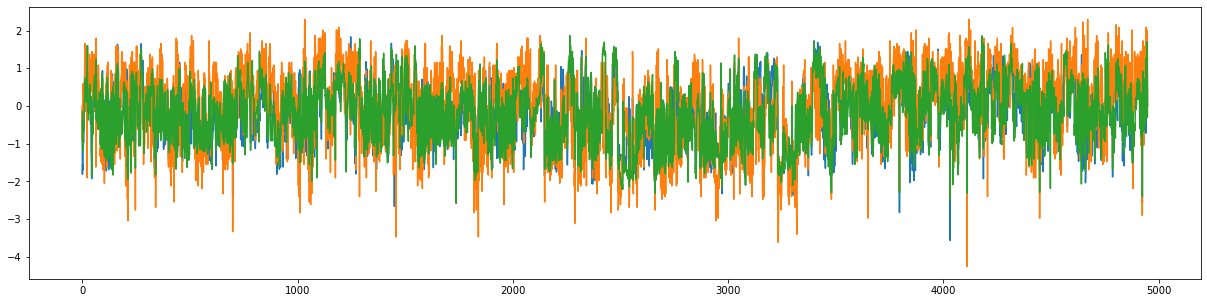

In [98]:
import matplotlib.pyplot as plt
#32 35 0
piece = 63
attr = ['velocity']
plt.figure(figsize=(21, 5))
plt.plot(Yhat[piece][:,0])
plt.plot(val[piece][0][1].loc[:,attr].to_numpy()[:])
plt.plot(Y16[piece][:,0])
# print(test_sequences[piece][1].columns[attr])
plt.show()

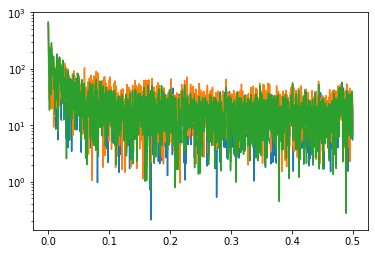

In [117]:
from scipy.fft import fft, fftfreq
from scipy.signal import blackman
from scipy.ndimage.filters import uniform_filter1d

piece = 63
n = len(Yhat[piece][:,0])
w = blackman(n)
yf = fft(Yhat[piece][:,0]*w)
xf = fftfreq(n)[:n//2]

valf = fft(val[piece][0][1].loc[:,attr].to_numpy().flatten()*w)
y16f = fft(Y16[piece][:,0]*w)
plt.semilogy(xf, np.abs(yf[:n//2]))
plt.semilogy(xf, np.abs(valf[:n//2]))
plt.semilogy(xf, np.abs(y16f[:n//2]))
plt.show()
#plt.xlim(right=0.1)

In [115]:
valf.flatten().shape

(4949,)

#### Comparison of dynamics of different performances of same piece for context:

In [ ]:
import matplotlib.pyplot as plt
with open(os.path.join(pathRoot, 'single fold/LvB_train_sequences.data'), 'rb') as seq_path:
    trainsf = pickle.load(seq_path)
attr = 'ioiRatio'
plt.figure(figsize=(21, 5))
plt.plot(trainsf[35][0][1].loc[:,attr].to_numpy()[2500:])
plt.plot(trainsf[70][0][1].loc[:,attr].to_numpy()[2500:])
plt.figure(figsize=(21, 5))
plt.plot(trainsf[42][0][1].loc[:,attr].to_numpy()[1000:1300])
plt.plot(trainsf[77][0][1].loc[:,attr].to_numpy()[1000:1300])

In [ ]:
with open(os.path.join(pathRoot, 'single fold/LvB_train_sequences.data'), 'rb') as seq_path:
    trainsf = pickle.load(seq_path)
attr = 'ioiRatio'
mse_human1 = np.mean((trainsf[70][0][1].loc[:, attr].iloc[:3120].to_numpy('float64') - trainsf[35][0][1].loc[:, attr].iloc[:3120].to_numpy('float64')) ** 2)
mse_human2 = np.mean((trainsf[42][0][1].loc[:, attr].to_numpy('float64') - trainsf[77][0][1].loc[:, attr].to_numpy('float64')) ** 2)

print("MSE between two performances of sonata 7, 2nd mvmt. (has alignment issues): " + str(mse_human1))
print("MSE between two performances of sonata 7, 3rd mvmt.: " + str(mse_human2))

#### Listen to a piece synthesized with the generated expression

In [ ]:
import pretty_midi
import IPython.display
import expression_modeling as m

with open(pathRoot + args.pitch_dict, 'rb') as filehandle:
    lex_to_ix = pickle.load(filehandle)
    ix_to_lex = {v: k for k, v in lex_to_ix.items()}
with open(pathRoot + args.norm, 'rb') as filehandle:
    moments, cols = pickle.load(filehandle)
    moments = dict(zip(cols, list(moments)))
with open(os.path.join(pathRoot, args.test_data), 'rb') as seq_path:
    test = pickle.load(seq_path)

# piece to synthesize:
pieceNum = 0
pieceId = val[pieceNum][1]
print(pieceId)

pred = Yhat[pieceNum][:,:2]
ref = val[pieceNum][0][1].ioiRatio
no_dev = np.asarray([val[pieceNum][0][2][2,0]] * val[pieceNum][0][1].shape[0])
dev_rand = np.random.normal(size=val[pieceNum][0][1].shape[0]) * val[pieceNum][0][2][2,1] + val[pieceNum][0][2][2,0]

pm = m.midi_performance(val[pieceNum][0], pred, moments, ix_to_lex, method='ioiRatio')
IPython.display.Audio(pm.fluidsynth(fs=44100), rate=44100)